In [1]:
%load_ext autoreload
%autoreload 2

# Quick Start
Install using ``pip`` and then import and use one of the tracking readers. This example
loads a local file.tcx. From the data file, we obviously get time, altitude, distance, heart rate  and geo position (lat/long).


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#!pip install runpandas
import runpandas as rpd
activity = rpd.read_file('./sample.tcx')

In [4]:
activity.head(5)

,alt,dist,hr,lon,lat
time,,,,,
00:00:00,178.942627,0.000000,62,-79.093187,35.951880
00:00:01,178.942627,0.000000,62,-79.093184,35.951880
00:00:06,178.942627,1.106947,62,-79.093172,35.951868
00:00:12,177.500610,13.003035,62,-79.093228,35.951774
00:00:16,177.500610,22.405027,60,-79.093141,35.951732


The data frames that are returned by runpandas when
loading files is similar for different file types.
The dataframe in the above example is a subclass of the
``pandas.DataFrame`` and provides some additional features.
Certain columns also return specific ``pandas.Series`` subclasses,
which provides useful methods:

In [5]:
print (type(activity))
print(type(activity.alt))

<class 'runpandas.types.frame.Activity'>
<class 'runpandas.types.columns.Altitude'>


For instance, if you want to get the base unit for the altitude ``alt`` data or the distance ``dist`` data:

In [6]:
print(activity.alt.base_unit)
print(activity.alt.sum())

m
65883.68151855901


In [7]:
print(activity.dist.base_unit)
print(activity.dist[-1])

m
4686.31103516


The `Activity` dataframe also contains special properties that presents some statistics from the workout such as elapsed time, mean heartrate, the moving time and the distance of workout in meters.

In [8]:
#total time elapsed for the activity
print(activity.ellapsed_time)
#distance of workout in meters
print(activity.distance)
#mean heartrate
print(activity.mean_heart_rate())

0 days 00:33:11
4686.31103516
156.65274151436032


Occasionally, some observations such as speed, distance and others must be calculated based on available data in the given activity. In runpandas there are  special accessors (`runpandas.acessors`) that computes some of these metrics.  We will compute the `speed` and the `distance per position` observations using the latitude and longitude for each record and calculate the haversine distance in meters and the speed in meters per second.

In [9]:
#compute the distance using haversine formula between two consecutive latitude, longitudes observations.
activity['distpos']  = activity.compute.distance()
activity['distpos'].head()

time
00:00:00          NaN
00:00:01     0.333146
00:00:06     1.678792
00:00:12    11.639901
00:00:16     9.183847
Name: distpos, dtype: float64

In [10]:
#compute the distance using haversine formula between two consecutive latitude, longitudes observations.
activity['speed']  = activity.compute.speed(from_distances=True)
activity['speed'].head()

time
00:00:00         NaN
00:00:01    0.333146
00:00:06    0.335758
00:00:12    1.939984
00:00:16    2.295962
Name: speed, dtype: float64

Popular running metrics are also available through the runpandas acessors such as gradient, pace, vertical speed , etc.

In [11]:
activity['vam'] = activity.compute.vertical_speed()
activity['vam'].head()

time
00:00:00         NaN
00:00:01    0.000000
00:00:06    0.000000
00:00:12   -0.240336
00:00:16    0.000000
Name: vam, dtype: float64

Sporadically, there will be a large time difference between consecutive observations in the same workout. This can happen  when device is paused by the athlete or therere proprietary algorithms controlling the operating sampling rate of the device which can auto-pause when the device detects no significant change in position.  In runpandas there is an algorithm that will attempt to calculate the moving time based on the GPS locations, distances, and speed of the activity.

To compute the moving time, there is a special acessor that detects the periods of inactivity and returns the `moving` series containing all the observations considered to be stopped.

In [12]:
activity_only_moving = activity.only_moving()
print(activity_only_moving['moving'].head())

time
00:00:00    False
00:00:01    False
00:00:06    False
00:00:12     True
00:00:16     True
Name: moving, dtype: bool


Now we can compute the moving time, the time of how long the user were active.

In [13]:
activity_only_moving.moving_time

Timedelta('0 days 00:33:05')

Runpandas also provides a method  ``summary`` for summarising the activity through common statistics.  Such a session summary includes estimates of several metrics computed above with a single call.

In [14]:
activity_only_moving.summary()

Session                           Running: 26-12-2012 21:29:53
Total distance (meters)                                4686.31
Total ellapsed time                            0 days 00:33:11
Total moving time                              0 days 00:33:05
Average speed (km/h)                                   8.47656
Average moving speed (km/h)                            8.49853
Average pace (per 1 km)                        0 days 00:07:04
Average pace moving (per 1 km)                 0 days 00:07:03
Average cadence                                            NaN
Average moving cadence                                     NaN
Average heart rate                                     156.653
Average moving heart rate                                157.4
Average temperature                                        NaN
dtype: object

Now, let's play with the data. Let's show distance vs as an example of what and how we can create visualizations.  In this example, we will use the built in, matplotlib based plot function.

<AxesSubplot:xlabel='time'>

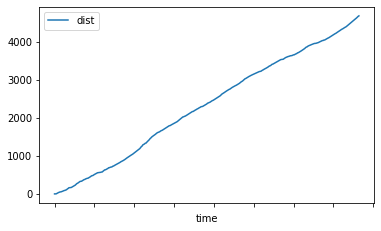

In [15]:
activity[['dist']].plot()

And here is altitude versus time.

<AxesSubplot:xlabel='time'>

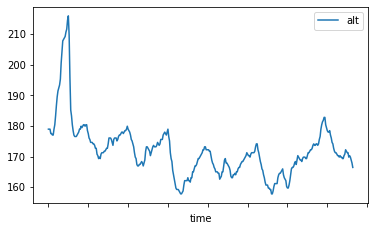

In [16]:
activity[['alt']].plot()

Finally, lest's show the altitude vs distance profile. Here is a scatterplot that shows altitude vs distance as recorded.

<AxesSubplot:xlabel='dist', ylabel='alt'>

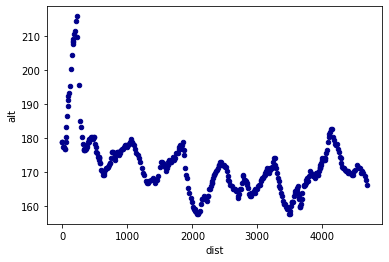

In [17]:
activity.plot.scatter(x='dist', y='alt', c='DarkBlue')

Finally, let's watch a  glimpse of the map route by plotting a 2d map using logintude vs latitude.

<AxesSubplot:xlabel='lon'>

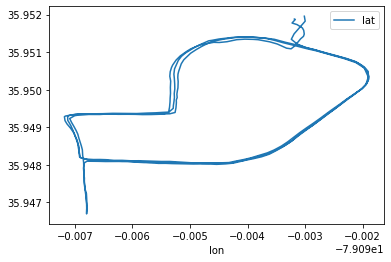

In [18]:
activity.plot(x='lon', y='lat')

Ok, a 2D map is cool. But would it be possible plot the route above on Google Maps ?   For this task, we will use a ready-made package called [gmplot](https://github.com/gmplot/gmplot). It uses the Google Maps API together with its Python library.

In [19]:
import gmplot

#let's get the min/max latitude and longitudes
min_lat, max_lat, min_lon, max_lon = \
min(activity['lat']), max(activity['lat']), \
min(activity['lon']), max(activity['lon'])

## Create empty map with zoom level 16
mymap = gmplot.GoogleMapPlotter(
    min_lat + (max_lat - min_lat) / 2, 
    min_lon + (max_lon - min_lon) / 2, 
    16, apikey='YOUR API KEY')
#To plot the data as a continuous line (or a polygon), we can use the plot method. It has two self-explanatory optional arguments: color and edge width.
mymap.plot(activity['lat'], activity['lon'], 'blue', edge_width=1)

#Draw the map to an HTML file.
mymap.draw('myroute.html')

In [20]:
#Show the map!
import IPython
IPython.display.HTML(filename='myroute.html')

The ``runpandas`` package also comes with extra batteries, such as our ``runpandas.datasets`` package, which includes a range of example data for testing purposes. There is a dedicated [repository](https://github.com/corriporai/runpandas-data) with all the data available. An index of the data is kept [here](https://github.com/corriporai/runpandas-data/blob/master/activities/index.yml).

You can use the example data available:

In [21]:
example_fit = rpd.activity_examples(path='Garmin_Fenix_6S_Pro-Running.fit')
print(example_fit.summary)
print('Included metrics:', example_fit.included_data)

Synced from watch Garmin Fenix 6S

Included metrics: [<MetricsEnum.latitude: 'latitude'>, <MetricsEnum.longitude: 'longitude'>, <MetricsEnum.elevation: 'elevation'>, <MetricsEnum.heartrate: 'heartrate'>, <MetricsEnum.cadence: 'cadence'>, <MetricsEnum.distance: 'distance'>, <MetricsEnum.temperature: 'temperature'>]


In [22]:
rpd.read_file(example_fit.path).head()

,enhanced_speed,enhanced_altitude,unknown_87,fractional_cadence,lap,session,unknown_108,dist,cad,hr,lon,lat,temp
time,,,,,,,,,,,,,
00:00:00,0.000,254.0,0,0.0,0,0,NaN,0.00,0,101,13.843376,51.066280,8
00:00:01,0.000,254.0,0,0.0,0,0,NaN,0.00,0,101,13.843374,51.066274,8
00:00:10,1.698,254.0,0,0.0,0,1,2362.0,0.00,83,97,13.843176,51.066249,8
00:00:12,2.267,254.0,0,0.0,0,1,2362.0,3.95,84,99,13.843118,51.066250,8
00:00:21,2.127,254.6,0,0.5,0,1,2552.0,16.67,87,100,13.842940,51.066231,8


In case of you just only want to see all the activities in a specific file type , you can filter the ``runpandas.activities_examples``, which returns a filter iterable that you can iterate over:


In [23]:
fit_examples = rpd.activity_examples(file_type=rpd.FileTypeEnum.FIT)
for example in fit_examples:
    #Download and play with the filtered examples
    print(example.path)

https://raw.githubusercontent.com/corriporai/runpandas-data/master/activities/Garmin_Fenix_6S_Pro-Running.fit
https://raw.githubusercontent.com/corriporai/runpandas-data/master/activities/Garmin_Fenix2_running_with_hrm.fit
https://raw.githubusercontent.com/corriporai/runpandas-data/master/activities/Garmin_Forerunner_910XT-Running.fit


# Exploring sessions

The package `runpandas` provides utilities to import a group of activities data, and after careful processing, organises them into a MultiIndex Dataframe.


The ``pandas.MultiIndex`` allows you to have multiple columns acting as a row identifier and multiple rows acting as a header identifier. In our scenario we will have as first indentifier (index) the timestamp of the workout when it started, and as second indentifier the timedelta of the consecutive observations of the workout.

![The MultiIndex Runpandas Activity Dataframe](MultiIndexDataframe.png "Illustration of the MultiIndex Dataframe")

The MultiIndex dataframe result from the function `runpandas.read_dir_aggregate`, which takes as input the directory of tracking data files, and constructs using the read*() functions to build `runpandas.Activity` objects. Them, the result daframes are first sorted by the time stamps and are all combined into a single `runpandas.Activity` indexed by the two-level `pandas.MultiIndex`.

Let's illustrate these examples by loading a bunch of 68 running activities of a female runner over the years of 2020 until 2021.


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import runpandas
session = runpandas.read_dir_aggregate(dirname='session/')

In [5]:
session

alt     hr        lon       lat
start                   time                                                 
2020-08-30 09:08:51.012 00:00:00              NaN    NaN -34.893609 -8.045055
                        00:00:01.091000       NaN    NaN -34.893624 -8.045054
                        00:00:02.091000       NaN    NaN -34.893641 -8.045061
                        00:00:03.098000       NaN    NaN -34.893655 -8.045063
                        00:00:04.098000       NaN    NaN -34.893655 -8.045065
...                                           ...    ...        ...       ...
2021-07-04 11:23:19.418 00:52:39.582000  0.050001  189.0 -34.894534 -8.046602
                        00:52:43.582000       NaN    NaN -34.894465 -8.046533
                        00:52:44.582000       NaN    NaN -34.894443 -8.046515
                        00:52:45.582000       NaN    NaN -34.894429 -8.046494
                        00:52:49.582000       NaN  190.0 -34.894395 -8.046398

[48794 rows x 4 columns]

Now let's see how many activities there are available for analysis. For this question, we also have an acessor ``runpandas.types.acessors.session._SessionAcessor`` that holds several methods for computing the basic running metrics across all the activities from this kind of frame and some summary statistics.

In [6]:
#count the number of activities in the session
print ('Total Activities:', session.session.count())

Total Activities: 68


We might compute the main running metrics (speed, pace, moving, etc) using the session acessors methods as like the ones available in the ``runpandas.types.metrics.MetricsAcessor`` . By the way, those methods are called inside each metric method, but applying in each of activities separatedely.

In [7]:
#In this example we compute the distance and the distance per position across all workouts
session = session.session.distance()
session

alt     hr        lon       lat  \
start                   time                                                    
2020-08-30 09:08:51.012 00:00:00              NaN    NaN -34.893609 -8.045055   
                        00:00:01.091000       NaN    NaN -34.893624 -8.045054   
                        00:00:02.091000       NaN    NaN -34.893641 -8.045061   
                        00:00:03.098000       NaN    NaN -34.893655 -8.045063   
                        00:00:04.098000       NaN    NaN -34.893655 -8.045065   
...                                           ...    ...        ...       ...   
2021-07-04 11:23:19.418 00:52:39.582000  0.050001  189.0 -34.894534 -8.046602   
                        00:52:43.582000       NaN    NaN -34.894465 -8.046533   
                        00:52:44.582000       NaN    NaN -34.894443 -8.046515   
                        00:52:45.582000       NaN    NaN -34.894429 -8.046494   
                        00:52:49.582000       NaN  190.0 -34.894395 -8.046398   

                                           distpos         dist  
start                   time                                     
2020-08-30 09:08:51.012 00:00:00               NaN          NaN  
                        00:00:01.091000   1.690587     1.690587  
                        00:00:02.091000   2.095596     3.786183  
                        00:00:03.098000   1.594298     5.380481  
                        00:00:04.098000   0.163334     5.543815  
...                                            ...          ...  
2021-07-04 11:23:19.418 00:52:39.582000  12.015437  8220.018885  
                        00:52:43.582000  10.749779  8230.768664  
                        00:52:44.582000   3.163638  8233.932302  
                        00:52:45.582000   2.851535  8236.783837  
                        00:52:49.582000  11.300740  8248.084577  

[48794 rows x 6 columns]

In [8]:
#comput the speed for each activity
session = session.session.speed(from_distances=True)
#compute the pace for each activity
session = session.session.pace()
#compute the inactivity periods for each activity
session = session.session.only_moving()

After all the computation done, let's going to the next step: the exploration and get some descriptive statistics.

After the loading and metrics computation for all the activities, now let's look further the data and get the basic summaries about the session: time spent, total distance, mean speed and other insightful statistics in each running activity.  For this task, we may accomplish it by calling the method ``runpandas.types.session._SessionAcessor.summarize`` .  It will return a basic Dataframe including all the aggregated statistics per activity from the season frame. 

In [9]:
summary = session.session.summarize()
summary

,moving_time,mean_speed,max_speed,mean_pace,max_pace,mean_moving_speed,mean_moving_pace,mean_cadence,max_cadence,mean_moving_cadence,mean_heart_rate,max_heart_rate,mean_moving_heart_rate,mean_temperature,min_temperature,max_temperature,total_distance,ellapsed_time
start,,,,,,,,,,,,,,,,,,
2020-07-03 09:50:53.162,00:25:29.838000,2.642051,4.879655,00:06:18,00:03:24,2.665008,00:06:15,NaN,NaN,NaN,178.819923,188.0,178.872587,NaN,NaN,NaN,4089.467333,00:25:47.838000
2020-07-05 09:33:20.999,00:05:04.999000,2.227637,6.998021,00:07:28,00:02:22,3.072098,00:05:25,NaN,NaN,NaN,168.345455,176.0,168.900000,NaN,NaN,NaN,980.162640,00:07:20.001000
2020-07-05 09:41:59.999,00:18:19,1.918949,6.563570,00:08:41,00:02:32,2.729788,00:06:06,NaN,NaN,NaN,173.894180,185.0,174.577143,NaN,NaN,NaN,3139.401118,00:27:16
2020-07-13 09:13:58.718,00:40:21.281000,2.509703,8.520387,00:06:38,00:01:57,2.573151,00:06:28,NaN,NaN,NaN,170.808176,185.0,170.795527,NaN,NaN,NaN,6282.491059,00:41:43.281000
2020-07-17 09:33:02.308,00:32:07.691000,2.643278,8.365431,00:06:18,00:01:59,2.643278,00:06:18,NaN,NaN,NaN,176.436242,186.0,176.436242,NaN,NaN,NaN,5095.423045,00:32:07.691000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-13 09:22:30.985,01:32:33.018000,2.612872,23.583956,00:06:22,00:00:42,2.810855,00:05:55,NaN,NaN,NaN,169.340812,183.0,169.655879,NaN,NaN,NaN,15706.017295,01:40:11.016000
2021-06-20 09:16:55.163,00:59:44.512000,2.492640,6.065895,00:06:41,00:02:44,2.749453,00:06:03,NaN,NaN,NaN,170.539809,190.0,171.231392,NaN,NaN,NaN,9965.168311,01:06:37.837000
2021-06-23 09:37:44.000,00:26:49.001000,2.501796,5.641343,00:06:39,00:02:57,2.568947,00:06:29,NaN,NaN,NaN,156.864865,171.0,156.957031,NaN,NaN,NaN,4165.492241,00:27:45.001000


In [11]:
print('Session Interval:', (summary.index.to_series().max() - summary.index.to_series().min()).days, 'days')
print('Total Workouts:', len(summary), 'runnings')
print('Tota KM Distance:', summary['total_distance'].sum() / 1000)
print('Average Pace (all runs):', summary.mean_pace.mean())
print('Average Moving Pace (all runs):', summary.mean_moving_pace.mean())
print('Average KM Distance (all runs):', round(summary.total_distance.mean()/ 1000,2))

Session Interval: 366 days
Total Workouts: 68 runnings
Tota KM Distance: 491.77377537338896
Average Pace (all runs): 0 days 00:07:18.411764
Average Moving Pace (all runs): 0 days 00:06:02.147058
Average KM Distance (all runs): 7.23


At this point, I have the summary data to start some powerful visualization and analysis. At the charts below we illustrate her pace and distance evolution over time.

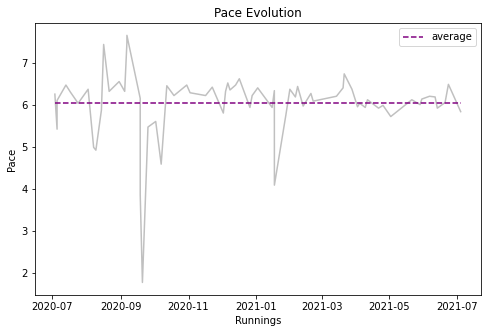

In [16]:
import matplotlib.pyplot as plt
import datetime

#let's convert the pace to float number in minutes
summary['mean_moving_pace_float'] = summary['mean_moving_pace'] / datetime.timedelta(minutes=1)
summary['pace_moving_all_mean'] = summary.mean_moving_pace.mean()
summary['pace_moving_all_mean_float'] = summary['pace_moving_all_mean'] / datetime.timedelta(minutes=1)

plt.subplots(figsize=(8, 5))

plt.plot(summary.index, summary.mean_moving_pace_float, color='silver')
plt.plot(summary.pace_moving_all_mean_float, color='purple', linestyle='dashed', label='average')
plt.title("Pace Evolution")
plt.xlabel("Runnings")
plt.ylabel("Pace")
plt.legend()

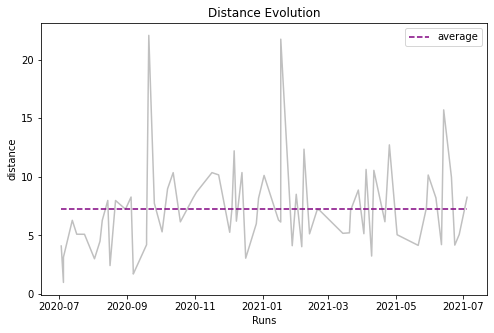

In [19]:

plt.subplots(figsize=(8, 5))

summary['distance_all_mean'] = round(summary.total_distance.mean()/1000,2)

plt.plot(summary.index, summary.total_distance / 1000, color='silver')
plt.plot(summary.distance_all_mean, color='purple', linestyle='dashed', label='average')
plt.title("Distance Evolution")
plt.xlabel("Runs")
plt.ylabel("distance")
plt.legend()


plt.show()